# Rotterdam stylized case

In [1]:
from classes import *
import copy
import csv
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path
#import ipywidgets as widgets
import pickle
import random

import tqdm


from models import Rotty
from mayors import *

### Load the model with parameters

In [2]:
Rotty

Rotty 
-----------
allFloodProtection: 
No 3.5; Dike 4.5;  
-----------
allResidentialArea: 
Area_A Protected by:['No']
Area_B Protected by:['Dike']

Parameters : 
{'Gumbel': OrderedDict([('mu', 2.33), ('beta', 0.234)]), 'I_experience_interp': {'xp': [0, 0.5], 'fp': [0, 1]}, 'I_social': 1}

### Load storm surge scenarios

In [3]:
# Load all SLR_Scenario
allSLR_Scenario = SLR_Scenario_from_pickles(Path('SLR_projections','Transients'))

# Load all SurgeHeight (Realisations of extreme value distribution)
for filename in Path('SurgeHeight','biased_from_five_hundred').glob('*.csv'):
    obj = SurgeHeight(filename.stem) #Init object with name derived from filename
    obj.from_csv(filename) #Fill the object with data from the csv file

# Create SurgeLevels by summing combinations of SLR_Scenario and SurgeHeights
for SLR_Scenario in allSLR_Scenario:
    for SurgeHeight in allSurgeHeight:
        combine_SurgeLevel(SLR_Scenario,SurgeHeight)
        
# Print all available SLR scenarios
for SLR_Scenario in allSLR_Scenario:
    print(SLR_Scenario.name,end=' ||| ')

Scenario_01 ||| Scenario_02 ||| Scenario_03 ||| Scenario_04 ||| Scenario_05 ||| Scenario_06 ||| Scenario_07 ||| Scenario_08 ||| Scenario_09 ||| 

### Run this block if you want to focus on a subset of the scenarios

In [83]:
selected_SH = ['five_hundred_18','five_hundred_41']

In [84]:
#Select two random SurgeHeight series
#selected_SH = random.sample(allSurgeHeight,2)
#selected_SH = [x.name for x in selected_SH]
#print(selected_SH)
#And a SLR scenirio
selected_SLR = ['03']

selection =  [x for x in allSurgeLevel if (x.corresponding_SLR_Scenario.name.split("_")[1] in selected_SLR and x.corresponding_SurgeHeight.name in selected_SH)]
selection

[Scenario_03__five_hundred_18, Scenario_03__five_hundred_41]

### Load adaptation strategies (Mayors)

In [85]:
allMayors = [Reactive(),Economicus(),Sentiment(),Lawkeeper()]

### Load implementation times

In [86]:
Implementation_times = [ #small measure, large measure
    (4,6),
    #(5,7),
    #(6,9), 
    #(7,10), #default
    #(8,11),
    (9,13),
    #(10,14),
    #(11,16),
    #(12,17),
    #(13,19),
    (14,20)]
Implementation_times

[(4, 6), (9, 13), (14, 20)]

### Model run algorithm

In [87]:
from run_model import run_model01

# Run the behaviour of one Mayor

In [88]:
#run one mayor:
all_experiments = []
for IT in Implementation_times:
    experiments = []
    for SurgeLevel in selection:
        experiment = run_model01(Rotty,SurgeLevel,Economicus(),Implementation_time=IT,do_print=True)
        experiments.append(experiment)
    all_experiments.append(experiments)
print(all_experiments)
print('experiments finished')

Finished experiment Rotty_Scenario_03__five_hundred_18_H. Economicus_(4, 6) 2021/03/02, 11:57:22
Finished experiment Rotty_Scenario_03__five_hundred_41_H. Economicus_(4, 6) 2021/03/02, 11:57:22
Finished experiment Rotty_Scenario_03__five_hundred_18_H. Economicus_(9, 13) 2021/03/02, 11:57:23
Finished experiment Rotty_Scenario_03__five_hundred_41_H. Economicus_(9, 13) 2021/03/02, 11:57:23
Finished experiment Rotty_Scenario_03__five_hundred_18_H. Economicus_(14, 20) 2021/03/02, 11:57:23
Finished experiment Rotty_Scenario_03__five_hundred_41_H. Economicus_(14, 20) 2021/03/02, 11:57:24
[[Rotty_Scenario_03__five_hundred_18_H. Economicus_(4, 6) 2021/03/02, 11:57:22, Rotty_Scenario_03__five_hundred_41_H. Economicus_(4, 6) 2021/03/02, 11:57:22], [Rotty_Scenario_03__five_hundred_18_H. Economicus_(9, 13) 2021/03/02, 11:57:23, Rotty_Scenario_03__five_hundred_41_H. Economicus_(9, 13) 2021/03/02, 11:57:23], [Rotty_Scenario_03__five_hundred_18_H. Economicus_(14, 20) 2021/03/02, 11:57:23, Rotty_Scenar

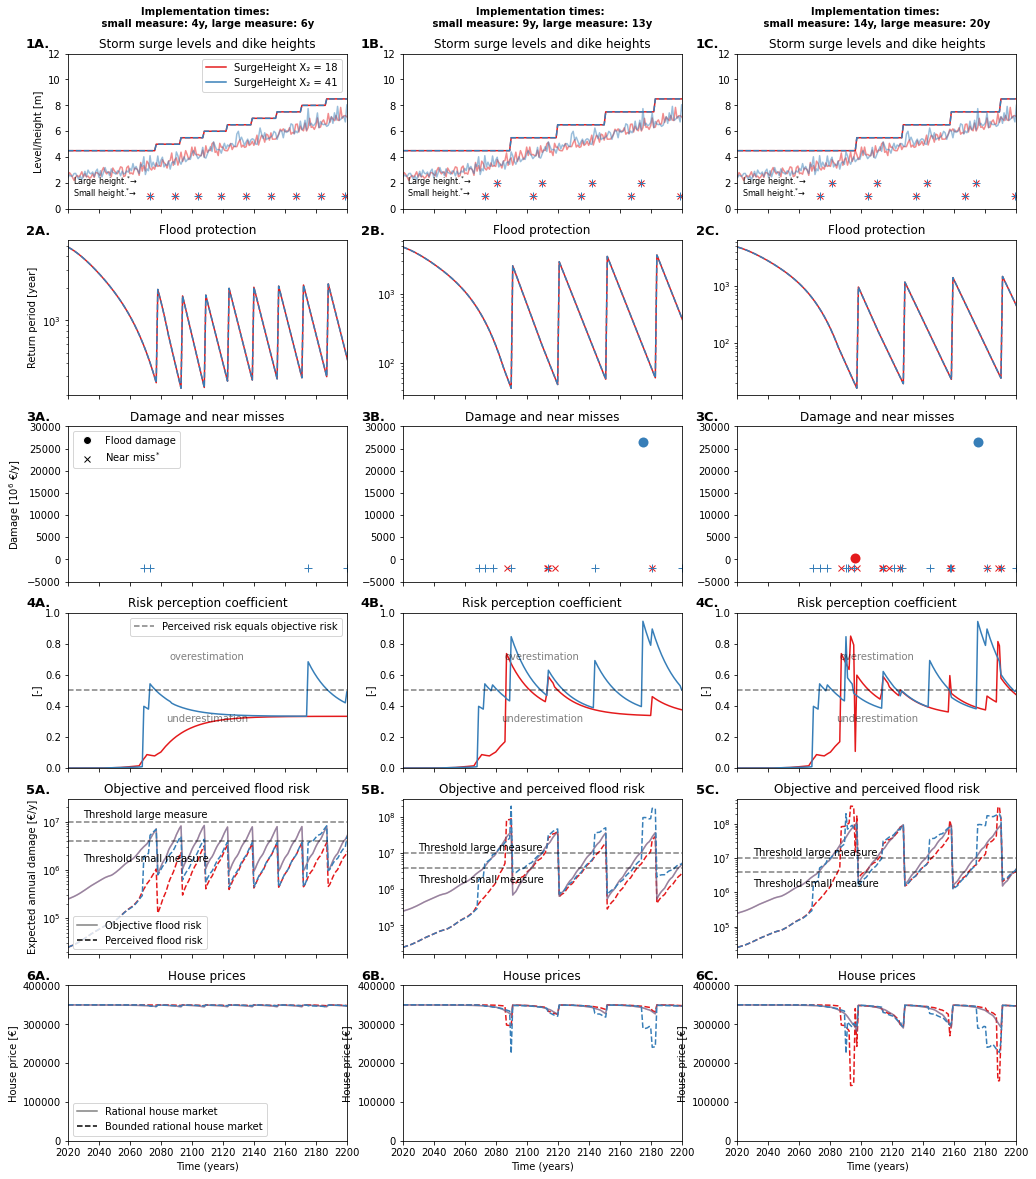

In [114]:
surgelevel_alpha = 0.5

p1 = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
p2 = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
p = p1

measure_cycler = ["x","+"] * 2
measure_cycler_size = [6,8] * 2

near_miss_cycler = ["x","+"] * 2
near_miss_size = [6,8] *2

damage_fill_cycler = ['full'] * 2

dike_linestyle_cyc = ['-','--']

nrows=6
ncols=3

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,sharey=False,sharex=True,figsize=(17,20))

xlim = (2020,2200)

for m, experiments in enumerate(all_experiments): #Iterates over surgeseries
    handles0 = []
    for j,experiment in enumerate(experiments): #Iterates of SLR scenarios
        Model = experiment.Model
        SurgeLevel = experiment.SurgeLevel
        Mayor = experiment.Mayor
        IT = experiment.ImplementationTime
        RA = Model.allResidentialArea[1]
        time = SurgeLevel.years
        
        
        #ROW 1 SURGELEVEL AND DIKE HEIGHT
        axes[0,m].plot(time,SurgeLevel.surgelevel,color=p[j],alpha=surgelevel_alpha)
        axes[0,m].plot(time,Model.allFloodProtection[1].protection_level,color=p[j],linestyle=dike_linestyle_cyc[j])
        
        #ROW 1 MEASURE HISTORY
        y_offset = 0 #0.05
        mh = [m for m in Model.allFloodProtection[1].measure_history]
        mh = [None if m == 0 else (2*m)+(j-1.5)*y_offset for m in mh]
        axes[0,m].plot(time,mh,measure_cycler[j],markersize=measure_cycler_size[j],color=p[j]) #PLOT THE HISTORY OF THE MEASURES
        
        #prepare labels
        labelSH = SurgeLevel.corresponding_SurgeHeight.name.split('_')[-1]
        label = 'SurgeHeight X{} = '.format(u'\u2082') + labelSH
        handles0.append(Line2D([0], [0], color=p[j], label=label,linestyle='-'))
        
        #ROW 2 FLOOD PROTECTION LEVEL
        axes[1,m].plot(time,RA.protection_level_rp,color=p[j],linestyle=dike_linestyle_cyc[j])
        axes[1,m].set_yscale("log")
        axes[1,0].set_ylabel('Return period [year]')
        
        
        
        #ROW 3 FLOOD DAMAGE AND WAKE UP SIGNALS
        axes[2,m].plot(time,(np.array(RA.flood_damage)*10e-6),'o',color=p[j], \
                       markersize=10,fillstyle=damage_fill_cycler[j],markeredgecolor=None, markeredgewidth=0.0)     
        axes[2,0].set_ylabel('Damage [10$^6$ \u20ac/y]')
        
        axes[2][m].set_ylim(-5000,30000)
        temp = [-2000 if x=='!' else None for x in RA.event_history]
        axes[2][m].plot(time,temp,near_miss_cycler[j],color=p[j],markersize=near_miss_size[j])
        
        
        #ROW 4 RISK PERCEPTION COEFFICIENT
        axes[3,m].set_title('Risk perception coefficient')
        axes[3,m].plot(time,RA.risk_perception,'-',color=p[j])
        axes[3,m].set_ylabel('[-]')
        axes[3,m].set_ylim(0,1)
        
        #ROW 5 OBJECTIVE AND PERCEIVED FLOOD RISK
        axes[4,m].set_title('Objective and perceived flood risk')
        unit_corr = [x * 10**6 for x in RA.risk]
        unit_corr2 = [x * 10**6 for x in RA.risk_perceived]
        axes[4,m].plot(time,unit_corr,'-',color=p[j],alpha=0.5)
        axes[4,m].set_yscale("log")
        axes[4,0].set_ylabel('Expected annual damage [\u20ac/y]')
        
        unit_corr2 = [x * 10**6 for x in RA.risk_perceived]
        axes[4,m].plot(time,unit_corr2,'--',color=p[j])
        
        #ROW 6 HOUSE PRICES
        axes[5,m].set_title('House prices')
        axes[5,m].plot(time,RA.house_price_t_objective,color=p[j],alpha=0.5)
        axes[5,m].set_ylim(0,4e5)
        axes[5,m].plot(time,RA.house_price_t_subjective,'--',color=p[j])
    
    
    #MAIN TITLE
    axes[0,m].text(0.5,1.3,'Implementation times: \n small measure: {}y, large measure: {}y \n'.format( \
        IT[0],IT[1]),fontsize=10,transform=axes[0,m].transAxes,fontweight='bold', va='top',ha='center')
    
    #ROW 1: STORM SURGE LEVEL, DIKE HEIGHT, MEASURES
    axes[0,m].set_title('Storm surge levels and dike heights')
    axes[0,0].set_ylabel('Level/height [m]')
    axes[0,m].set_ylim(-0,12)
    
    axes[0,m].text(2023,0.9,'Small height.$^{*}$' + u"\u2192",fontsize=8)
    axes[0,m].text(2023,1.9,'Large height.$^{*}$' + u"\u2192",fontsize=8)
    
    axes[0,0].legend(handles=handles0)
    
    #ROW 2 FLOOD PROTECTION LEVEL
    axes[1,m].set_title('Flood protection')
    
    #ROW 3 DAMAGE AND NEAR MISSES
    axes[2,m].set_title('Damage and near misses')
    handles2 = [Line2D([0], [0], marker='o', color='w', label='Flood damage', markerfacecolor='black', markersize=8),
             Line2D([0], [0], marker='x', color='w', label='Near miss$^{*}$', markeredgecolor='black', markersize=6)]
    axes[2,0].legend(handles=handles2,loc='upper left')
    
    
    #ROW 4 RISK PERCEPTION
    alpha = 0.5
    color = 'black'
    axes[3,m].plot(time,[0.5]*len(time),color=color,linestyle='--',alpha = alpha)    
    #Manually add legend patches
    custom_line = [Line2D([0], [0], color=color, alpha=alpha,label='Perceived risk equals objective risk',linestyle='--')]
    axes[3,0].legend(handles=custom_line)
    axes[3,m].text(0.5,0.3,'underestimation',color=color,alpha=alpha,transform=axes[3,m].transAxes,ha='center')
    axes[3,m].text(0.5,0.7,'overestimation',color=color,alpha=alpha,transform=axes[3,m].transAxes,ha='center')
    
    #ROW 5 FLOOD RISK
    #Manually add legend patches
    custom_lines = [Line2D([0], [0], color='black',label='Objective flood risk',linestyle='-',alpha=0.5),
                        Line2D([0], [0], color='black',label='Perceived flood risk',linestyle='--')]
    axes[4,0].legend(handles=custom_lines,loc='lower left')
    
    #ROW 6 HOUSE PRICE
    custom_lines = [Line2D([0], [0], color='black',label='Rational house market',linestyle='-',alpha=0.5),
                        Line2D([0], [0], color='black',label='Bounded rational house market',linestyle='--')]
    axes[5,0].legend(handles=custom_lines)
    axes[5,m].set_ylabel('House price [\u20ac]')
    axes[5,m].set_xlabel('Time (years)')
    
    ############### PRINT MAYOR-SPECIFIC THRESHOLDS ####################
    if Mayor.get_name() == 'Lawkeeper':
        axes[1,m].plot(time,[Mayor.threshold_small]*len(time),color='black',linestyle='--',alpha=0.5)
        axes[1,m].plot(time,[Mayor.threshold_large]*len(time),color='black',linestyle='--',alpha=0.5)
        axes[1,m].text(2030,Mayor.threshold_small - 4000,'Threshold small measure',color='black',alpha=1)
        axes[1,m].text(2030,Mayor.threshold_large - 800,'Threshold large measure',color='black',alpha=1)

    if Mayor.get_name() == 'H. Economicus' or Mayor.get_name() == 'Sentiment':
        axes[4,m].plot(time,[(10**6)*Mayor.threshold_small]*len(time),color='black',linestyle='--',alpha=0.5)
        axes[4,m].plot(time,[(10**6)*Mayor.threshold_large]*len(time),color='black',linestyle='--',alpha=0.5)
        axes[4,m].text(2030,(10**6)*Mayor.threshold_small-2.5E6,'Threshold small measure',color='black',alpha=1)
        axes[4,m].text(2030,(10**6)*Mayor.threshold_large+2E6,'Threshold large measure',color='black',alpha=1)
    
    ###################################################################
    

#Set xlim of each axis to the same value
for row in axes: 
    for ax in row: ax.set_xlim(xlim)
        
for nr in range(0,nrows):
    for l,letter in enumerate(('A','B','C')):
        axes[nr,l].text(-0.15, 1.1, "{}{}.".format(nr+1,letter), transform=axes[nr,l].transAxes,
                       fontsize=13, fontweight='bold', va='top')

In [115]:
#################################################################    
#################### SAVE THE EXPERIMENT ########################
#################################################################

its = IT
filename = "NB02_" + experiment.Mayor.get_name() + "_trans_" + experiment.SurgeLevel.name.split("__")[1] + "_it_" + str(its)
print(filename)

#CREATE SUBFOLDER IN VISUALISATION WITH CURRENT DATE
today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)
target = Path('Visualisations',date)
if not Path.exists(target): target.mkdir()
else: print("Target folder {} already exists".format(target))

fig.savefig(Path(target, (filename + ".png")),bbox_inches='tight',dpi=150)

NB02_H. Economicus_trans_five_hundred_41_it_(14, 20)
Target folder Visualisations\2021_3_2 already exists
